In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
from pykalman import KalmanFilter

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ;

In [3]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [4]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-13,11.098924,10.915088,11.393015,13.552846,12.807653,13.594864,12.857095,12.200557,11.481435,12.187909,...,12.022150,11.259323,9.132379,9.757305,10.426588,9.545741,9.620461,9.486456,9.381348,11.630308
2023-04-14,11.083680,10.918718,11.399757,13.543702,12.800780,13.594864,12.854484,12.186380,11.475224,12.201060,...,12.034097,11.267025,9.133459,9.747418,10.430137,9.559235,9.615805,9.497772,9.371609,11.630486
2023-04-17,11.086747,10.927735,11.390758,13.534473,12.802158,13.598598,12.926348,12.180755,11.472103,12.190959,...,12.033503,11.254155,9.134539,9.746834,10.430433,9.560645,9.614471,9.482274,9.381769,11.625227
2023-04-18,11.091331,10.927735,11.380536,13.548937,12.854484,13.623139,12.999065,12.162121,11.478334,12.169409,...,12.007622,11.302204,9.118225,9.763651,10.428955,9.558882,9.599337,9.475393,9.385553,11.625003
2023-04-19,11.092854,10.924138,11.385092,13.543702,12.849241,13.615839,12.988832,12.163165,11.480402,12.165771,...,12.013701,11.359774,9.121509,9.760771,10.432350,9.559588,9.598320,9.477692,9.386392,11.622721


In [5]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-13,65600,55100,89500,753000,365500,760000,369000,199000,97800,196200,...,165200,77800,9120,17180,33515,13780,15065,13155,11950,112480
2023-04-14,66600,55700,90100,773000,368500,812000,394000,199500,97200,198700,...,166700,78400,9300,17230,33950,14050,14925,13300,11830,112195
2023-04-17,65000,55100,89000,757000,362500,802000,395500,195400,96300,199000,...,168400,78300,9290,17110,33850,14175,15015,13060,11800,112475
2023-04-18,65900,55700,89300,755000,365500,822000,425000,192700,95500,196100,...,166600,77100,9190,17020,33900,14145,14705,12995,11915,112505
2023-04-19,65500,55700,88000,766000,383500,820000,436000,191400,96300,192400,...,164800,82900,9120,17420,33810,14170,14740,13070,11925,112990


<AxesSubplot:xlabel='Date'>

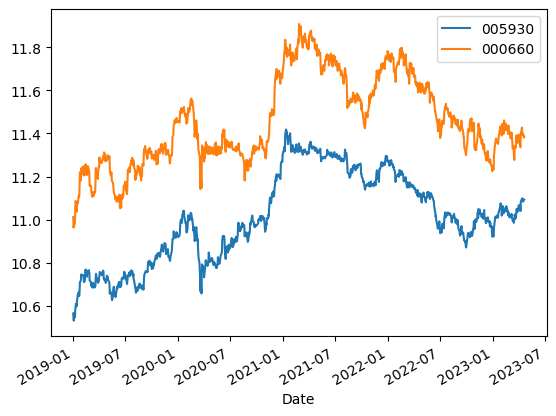

In [6]:
a0, a1 = '005930', '000660'
x = logp[a0]
y = logp[a1]
x.plot(legend=True)
y.plot(legend=True)

In [7]:
x.shape

(1063,)

C:\Users\USER\AppData\Local\Temp\ipykernel_10616\2125577369.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])


Text(0, 0.5, 'y')

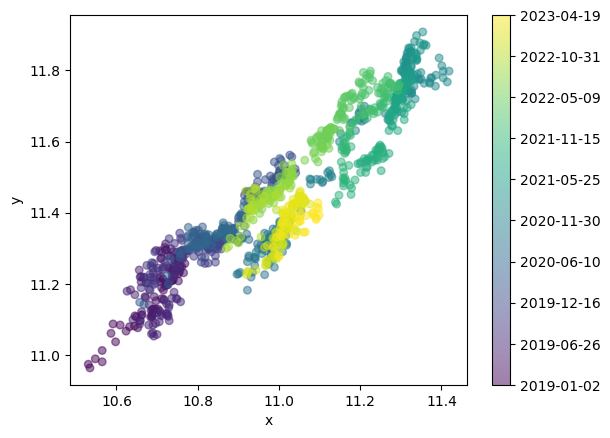

In [8]:
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, alpha=0.5)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('x')
plt.ylabel('y')

In [47]:
delta = 1e-1
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
#trans_cov = np.diag([2e-6, 1e-4])
obs_mat = sm.add_constant(x.values, prepend=False)[:, np.newaxis]

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[1,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [48]:
# delta = 1e-2
# trans_cov = delta / (1 - delta) * np.eye(1) # How much random walk wiggles
# obs_mat = x.values[:, np.newaxis][:, np.newaxis]

# kf = KalmanFilter(n_dim_obs=1, n_dim_state=1, 
#                   initial_state_mean=[1],
#                   initial_state_covariance=np.ones((1, 1)),
#                   transition_matrices=np.eye(1),
#                   observation_matrices=obs_mat,
#                   observation_covariance=1,
#                   transition_covariance=trans_cov)

In [49]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

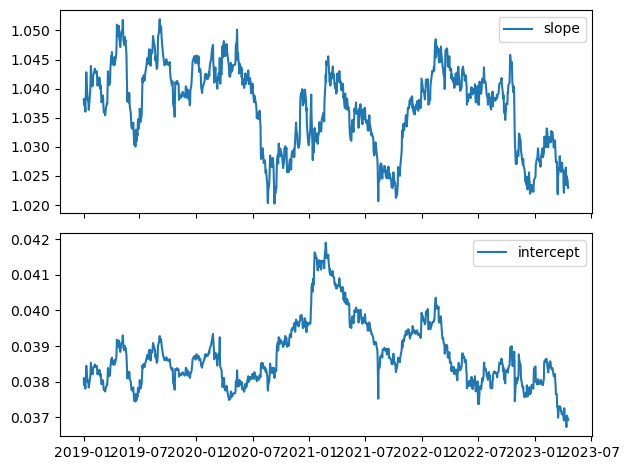

In [50]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

In [51]:
beta = state_means[:,0]
alpha = state_means[:,1]

In [52]:
data = logp[[a0, a1]]
p_data = p[[a0, a1]]
p_open_data = p_open[[a0, a1]]

<AxesSubplot:xlabel='Date'>

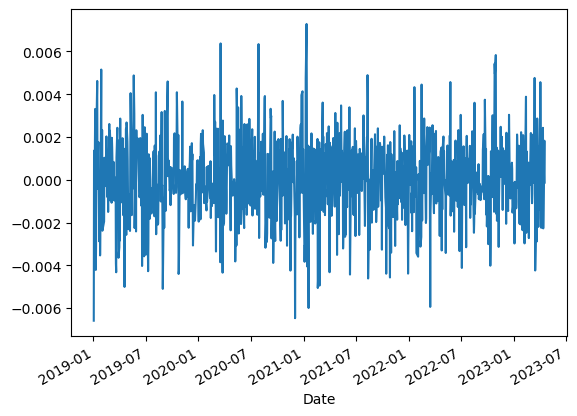

In [53]:
sp = beta*x - y + alpha
sp.plot()

In [265]:
def get_pnl_ratio(delta, obscov):
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = sm.add_constant(x.values, prepend=False)[:, np.newaxis]

    try:
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                          initial_state_mean=[1,0],
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_mat,
                          observation_covariance=obscov,
                          transition_covariance=trans_cov)

        state_means, state_covs = kf.filter(y.values)
        beta = state_means[:,0]
        alpha = state_means[:,1]
    
        w, _ = getStrategyPortfolioWeights(beta, alpha, a0, a1, data, smoothing_window=1)
        _, _, pct_rtns, _, _, _, _ = backtest(p_data, p_open_data, w, 1e8)
        return pct_rtns[-1]
    
    except:
        return 0

In [273]:
deltas = np.linspace(0.00001, 0.1, 10)
obscovs = np.linspace(0.01, 2, 10)

res = []
for _d in tqdm(deltas):
    for i, _o in enumerate(obscovs):
        #set_trace()
        if i==0:
            res.append([])
            
        _r = get_pnl_ratio(_d, _o)
        res[-1].append(_r)

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
def getStrategyPortfolioWeights(beta, alpha, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1]
    data2 = data[stock_name2]
    
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(beta[i])
            fixed_alpha = float(alpha[i])
            
            signal = fixed_beta*data1 - data2 + fixed_alpha
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
                w0 = fixed_beta / (abs(fixed_beta)+1)
                w1 = -1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "long"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="long":
            # a failed trade
#             if smoothed_signal[i] < trading_start:
#                 leverage.iloc[i,0] = 0
#                 leverage.iloc[i,1] = 0
#                 trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
#             if smoothed_signal[i] > trading_start:
#                 leverage.iloc[i,0] = 0
#                 leverage.iloc[i,1] = 0
#                 trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [20]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * 0.0001

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (leverageDF.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))
    pnl = pd.Series(pnl)
    hit_ratio = sum(pnl>0) / len(pnl) * 100
    pnl_ratio = -profit_of_profit_entry / loss_of_loss_entry

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    print(f'승률: {hit_ratio:.2f}%')
    print(f'손익률: {pnl_ratio:.2f}')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pnl,
        pnl_ratio
    )

테스트 일수: 1059일
순손익 (투자금액대비%): 61,149,088원 (61.149%)
총비용 (총손익대비%): 2,988,811원 (4.660%)
진입횟수: 76회
월평균 진입횟수: 1.44회
진입일수 (전체일수대비%): 220일 (20.77%)
평균보유일수: 2.89일
진입당 평균손익: 804,593원
최대수익: 6,955,492원
최대손실: -6,328,669원


<AxesSubplot:xlabel='Date'>

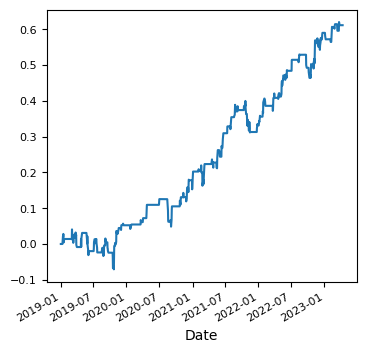

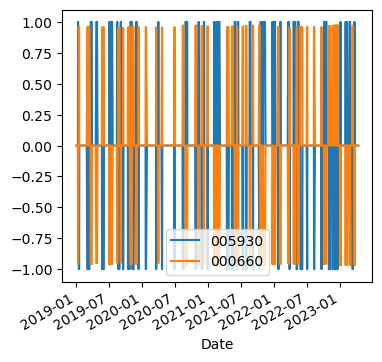

In [312]:
w5, signal5 = getStrategyPortfolioWeights(beta, a0, a1, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

<AxesSubplot:xlabel='Date'>

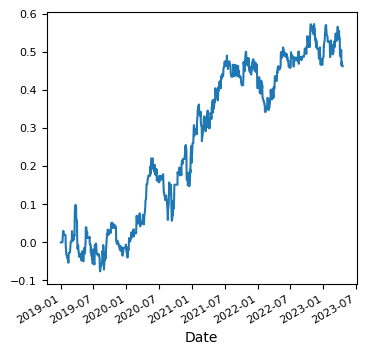

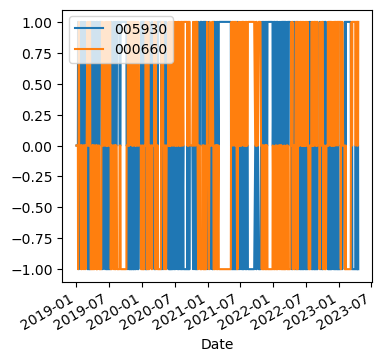

In [17]:
w5, signal5 = getStrategyPortfolioWeights(beta, alpha, a0, a1, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5, pnl_ratio5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

테스트 일수: 1063일
순손익 (투자금액대비%): 12,096,498원 (12.096%)
총비용 (총손익대비%): 1,564,351원 (11.451%)
진입횟수: 39회
월평균 진입횟수: 0.73회
진입일수 (전체일수대비%): 39일 (3.67%)
평균보유일수: 1.00일
진입당 평균손익: 310,166원
최대수익: 3,177,425원
최대손실: -3,385,674원
수익진입의 평균수익: 1,249,468원
손실진입의 평균손실: -1,192,716원
승률: 61.54%
손익률: 1.05


<AxesSubplot:xlabel='Date'>

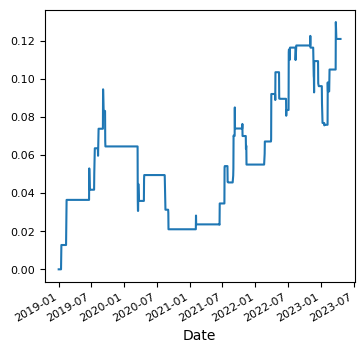

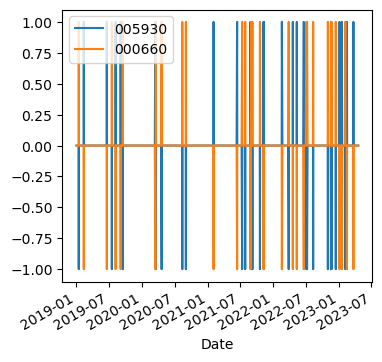

In [54]:
w5, signal5 = getStrategyPortfolioWeights(beta, alpha, a0, a1, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5, pnl_ratio5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)